In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt 
from uncertainties import ufloat, unumpy

def errorbar(xs, ys, **kwargs):
    plt.errorbar(unumpy.nominal_values(xs), unumpy.nominal_values(ys), xerr=unumpy.std_devs(xs), yerr=unumpy.std_devs(ys), **kwargs)


df = pd.read_csv("data21.csv")
df

,V_0,V_1,dV_1,V_2,dV_2
0,1.600000,2.154194,0.024474,0.023871,0.038983
1,1.631579,2.146452,0.015006,0.011935,0.004340
2,1.663158,2.125806,0.014783,0.018065,0.005806
3,1.694737,2.132581,0.011935,0.020968,0.007104
4,1.726316,2.121935,0.007038,0.025806,0.014498
5,1.757895,2.102903,0.013568,0.042581,0.008870
6,1.789474,2.091935,0.021507,0.050968,0.007328
7,1.821053,2.059677,0.019043,0.068065,0.015568
8,1.852632,2.037419,0.029254,0.079677,0.003548
9,1.884211,1.475161,0.026952,0.096129,0.004741


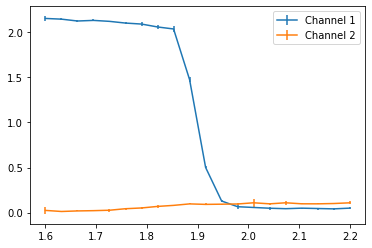

In [2]:
plt.errorbar(df['V_0'], df['V_1'], yerr=df['dV_1'], label='Channel 1')
plt.errorbar(df['V_0'], df['V_2'], yerr=df['dV_2'], label='Channel 2')
plt.legend()
plt.show()

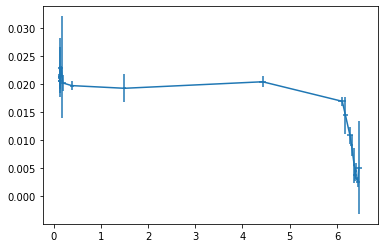

In [3]:
V_1 = unumpy.uarray(df['V_1'], df['dV_1'])
V_2 = unumpy.uarray(df['V_2'], df['dV_2'])

# V_out = 3 V_1
V_out = 3 * V_1
# I_out = V_2 / R (Approx)
I_out = V_2 / 4.7


errorbar(V_out, I_out)
# plt.plot(unumpy.nominal_values(V_out), unumpy.nominal_values(I_out))
plt.show()


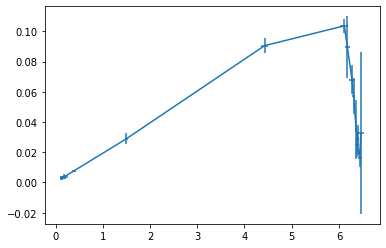

In [4]:
P_out = V_out * I_out
errorbar(V_out, P_out)
plt.show()

In [5]:
# I think we can fit this with the I-U characteristic:
from lmfit import models, Parameter, Parameters


def I(U, I_L, I_0):
    e = 1.6e-19
    k = 1.23e-23
    T = 300
    I1 = I_L - (10**I_0) * (np.exp((e * U) / (5 * k * T)))
    I1[I1 < 0] = 0
    return I1
    
UIModel = models.Model(I)
params = Parameters()
# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
params.add_many(('I_L', 0.02, True, 0, 1, None, 0.0005), ('I_0', -23, True, None, -3, None, 0.01))
result = UIModel.fit(unumpy.nominal_values(I_out), 
                     params=params, 
                     U=unumpy.nominal_values(V_out), 
                     weights=1/unumpy.std_devs(I_out))

print(result.fit_report())

[[Model]]
    Model(I)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 57
    # data points      = 20
    # variables        = 2
    chi-square         = 37.7339334
    reduced chi-square = 2.09632963
    Akaike info crit   = 16.6965501
    Bayesian info crit = 18.6880147
[[Variables]]
    I_L:  0.02059642 +/- 4.6057e-04 (2.24%) (init = 0.02)
    I_0: -25.6434903 +/- 0.06773447 (0.26%) (init = -23)
[[Correlations]] (unreported correlations are < 0.100)
    C(I_L, I_0) =  0.365


(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

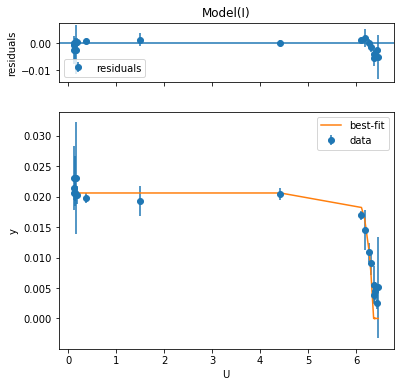

In [6]:
result.plot()

In [10]:
# So fitting is possible, although some adjustments to I() are neccesary. 
# I think we should be able to do the same thing with the power curve
# 1) power curve fit based on fitted I()
I_L, I_0 = ufloat(0.02059642, 4.6057e-04), ufloat(-25.6434903, 0.06773447)

def P(U, I_L, I_0):
    print(f"P() Called, U = {U}")
    return U * I(U, I_L, I_0)
    
UIModel = models.Model(P)
params = Parameters()
# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
params.add_many(('I_L', 0.02, True, 0, 1, None, 0.0005), ('I_0', -23, True, None, -3, None, 0.01))
result = UIModel.fit(unumpy.nominal_values(I_out * V_out), 
                     params=params, 
                     U=unumpy.nominal_values(V_out), 
                     weights=1/unumpy.std_devs(I_out * V_out))

print(result.fit_report())




P() Called, U = [6.46258065 6.43935484 6.37741935 6.39774194 6.36580645 6.30870968
 6.27580645 6.17903226 6.11225806 4.42548387 1.50193548 0.38419355
 0.19451613 0.16935484 0.14419355 0.12870968 0.14612903 0.13451613
 0.12290323 0.14709677]
P() Called, U = [6.46258065 6.43935484 6.37741935 6.39774194 6.36580645 6.30870968
 6.27580645 6.17903226 6.11225806 4.42548387 1.50193548 0.38419355
 0.19451613 0.16935484 0.14419355 0.12870968 0.14612903 0.13451613
 0.12290323 0.14709677]
P() Called, U = [6.46258065 6.43935484 6.37741935 6.39774194 6.36580645 6.30870968
 6.27580645 6.17903226 6.11225806 4.42548387 1.50193548 0.38419355
 0.19451613 0.16935484 0.14419355 0.12870968 0.14612903 0.13451613
 0.12290323 0.14709677]
P() Called, U = [6.46258065 6.43935484 6.37741935 6.39774194 6.36580645 6.30870968
 6.27580645 6.17903226 6.11225806 4.42548387 1.50193548 0.38419355
 0.19451613 0.16935484 0.14419355 0.12870968 0.14612903 0.13451613
 0.12290323 0.14709677]
P() Called, U = [6.46258065 6.439354

P() Called, U = [0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286 1.         1.14285714 1.28571429 1.42857143 1.57142857
 1.71428571 1.85714286 2.         2.14285714 2.28571429 2.42857143
 2.57142857 2.71428571 2.85714286 3.         3.14285714 3.28571429
 3.42857143 3.57142857 3.71428571 3.85714286 4.         4.14285714
 4.28571429 4.42857143 4.57142857 4.71428571 4.85714286 5.
 5.14285714 5.28571429 5.42857143 5.57142857 5.71428571 5.85714286
 6.         6.14285714 6.28571429 6.42857143 6.57142857 6.71428571
 6.85714286 7.        ]


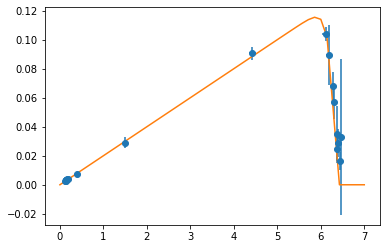

In [11]:
errorbar(V_out, P_out, fmt='o')
plt.plot(np.linspace(0, 7, 50), P(np.linspace(0, 7, 50), 0.02, -25.6))
plt.show()

In [12]:
# Maximum power is located at the max of the P(U) curve. 
from scipy import optimize

U_max = optimize.fmin(lambda U: -P(U, 0.02, -25.6), x0=5)[0]
print(U_max)



P() Called, U = [5.]
P() Called, U = [5.25]
P() Called, U = [5.5]
P() Called, U = [5.75]
P() Called, U = [6.25]
P() Called, U = [5.5]
P() Called, U = [6.]
P() Called, U = [5.875]
P() Called, U = [6.]
P() Called, U = [5.8125]
P() Called, U = [5.9375]
P() Called, U = [5.90625]
P() Called, U = [5.84375]
P() Called, U = [5.890625]
P() Called, U = [5.90625]
P() Called, U = [5.8828125]
P() Called, U = [5.8984375]
P() Called, U = [5.88671875]
P() Called, U = [5.89453125]
P() Called, U = [5.88867188]
P() Called, U = [5.89257812]
P() Called, U = [5.88964844]
P() Called, U = [5.89160156]
P() Called, U = [5.89013672]
P() Called, U = [5.88964844]
P() Called, U = [5.89038086]
P() Called, U = [5.890625]
P() Called, U = [5.89025879]
P() Called, U = [5.89013672]
P() Called, U = [5.89031982]
Optimization terminated successfully.
         Current function value: -0.115544
         Iterations: 15
         Function evaluations: 30
5.89031982421875
